In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


In [2]:
# libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn import metrics

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# General Information

* Goal: To similate the ventilator and correctly predict the airway pressure in the respiratory circuit during the breath.
* The different time series are used to predict the values of other time series. So this is a regression task and not a forecasting one.

# Data Loading and Overview

In [3]:
xtrain = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
xtrain.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [4]:
xtest = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')
xtest.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [5]:
xtrain.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


The dataset is large - more than 6 million rows. There are 2 categorical features (R and C), the id of a row, the id of a breath, timestamp and continuous variables.

In [6]:
xtrain.groupby('breath_id')['u_in'].count()

breath_id
1         80
2         80
3         80
4         80
5         80
          ..
125740    80
125742    80
125743    80
125745    80
125749    80
Name: u_in, Length: 75450, dtype: int64

In [7]:
xtest.groupby('breath_id')['u_in'].count()

breath_id
0         80
8         80
11        80
24        80
31        80
          ..
125741    80
125744    80
125746    80
125747    80
125748    80
Name: u_in, Length: 50300, dtype: int64

In [8]:
np.intersect1d(xtrain['breath_id'].unique(), xtest['breath_id'].unique())

array([], dtype=int64)

As the breath_id s do not overlap between train and test, for validation GroupKFold should be used.

/tmp/ipykernel_32/2828283075.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


Text(0.5, 1.0, 'Counts of C in test')

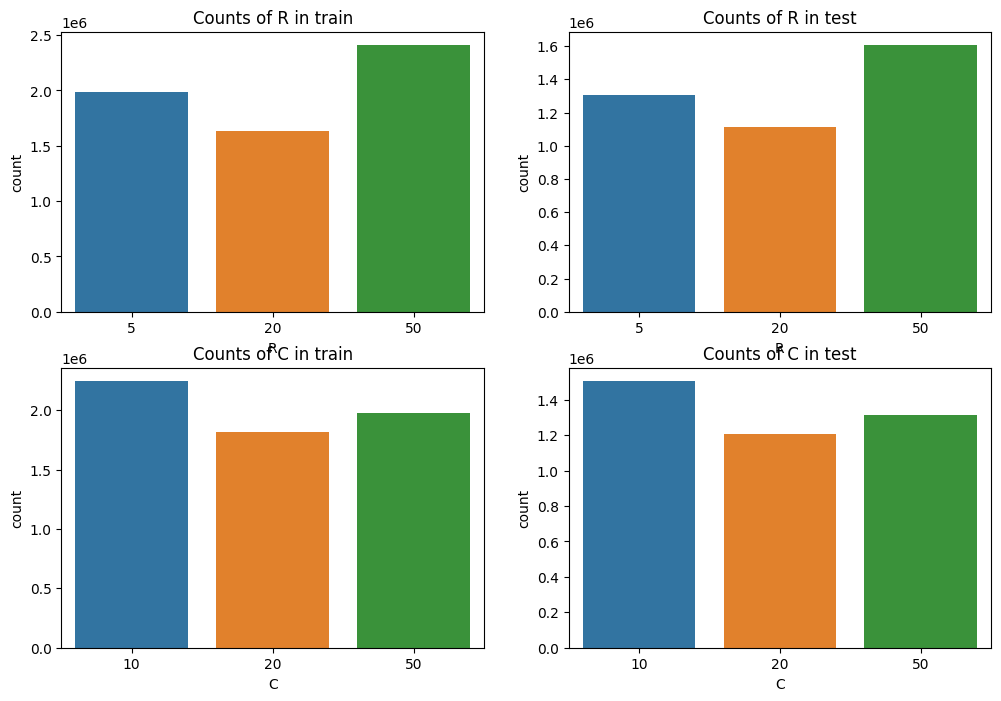

In [9]:
fig, ax = plt.subplots(figsize = (12,8))
plt.subplot(2,2,1)
sns.countplot(x='R', data=xtrain)
plt.title('Counts of R in train')
plt.subplot(2,2,2)
sns.countplot(x='R', data=xtest)
plt.title('Counts of R in test')
plt.subplot(2,2,3)
sns.countplot(x='C', data=xtrain)
plt.title('Counts of C in train')
plt.subplot(2,2,4)
sns.countplot(x='C', data=xtest)
plt.title('Counts of C in test')

R and C categroical variables have a similar distribution in train and test.

**Example time series**

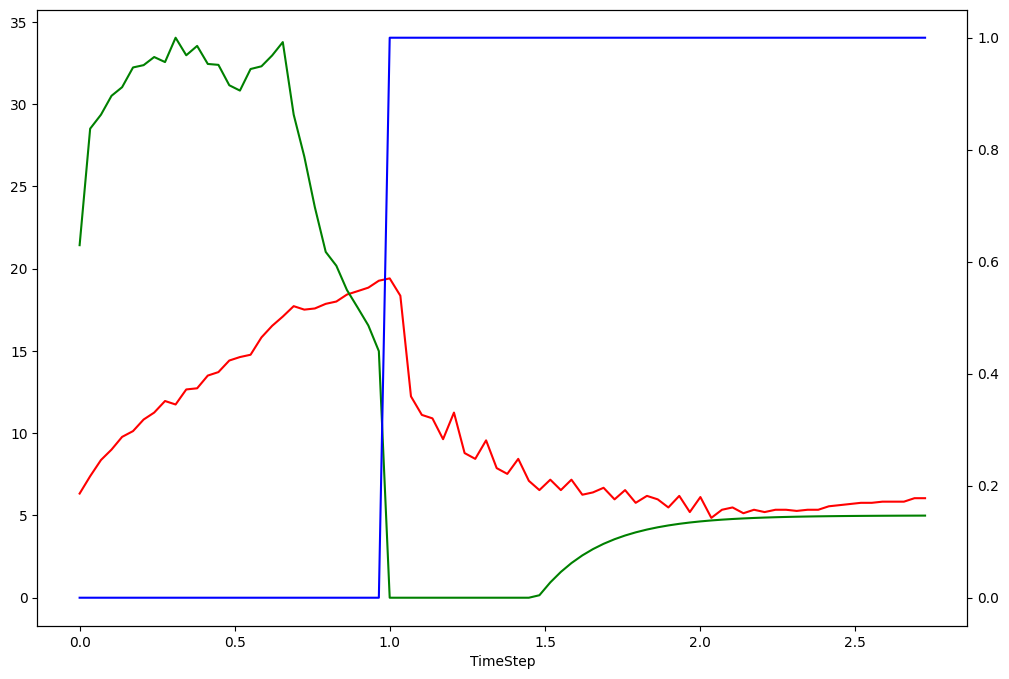

In [10]:
fig, ax1 = plt.subplots(figsize = (12,8))
breath_5 = xtrain.loc[xtrain['breath_id'] == 5]
ax2 = ax1.twinx()

ax1.plot(breath_5['time_step'], breath_5['pressure'], 'r-', label = 'pressure')
ax1.plot(breath_5['time_step'], breath_5['u_in'], 'g-', label = 'u_in')
ax2.plot(breath_5['time_step'], breath_5['u_out'], 'b-', label = 'u_out')

ax1.set_xlabel('TimeStep')
plt.show()

Pressure (target) drops abruptly once u_out = 1.0

# Feature Engineering:

**Lag Features**

In [5]:
xtrain['last_value_u_in'] = xtrain.groupby('breath_id')['u_in'].transform('last')

xtrain['u_in_lag1'] = xtrain.groupby('breath_id')['u_in'].shift(1)
xtrain['u_in_lag2'] = xtrain.groupby('breath_id')['u_in'].shift(2)
xtrain['u_in_lag3'] = xtrain.groupby('breath_id')['u_in'].shift(3)
xtrain['u_out_lag1'] = xtrain.groupby('breath_id')['u_out'].shift(1)
xtrain['u_out_lag2'] = xtrain.groupby('breath_id')['u_out'].shift(2)
xtrain['u_out_lag3'] = xtrain.groupby('breath_id')['u_out'].shift(3)

xtrain['u_in_lag_back1'] = xtrain.groupby('breath_id')['u_in'].shift(-1)
xtrain['u_in_lag_back2'] = xtrain.groupby('breath_id')['u_in'].shift(-2)
xtrain['u_in_lag_back3'] = xtrain.groupby('breath_id')['u_in'].shift(-3)
xtrain['u_out_lag_back1'] = xtrain.groupby('breath_id')['u_out'].shift(-1)
xtrain['u_out_lag_back2'] = xtrain.groupby('breath_id')['u_out'].shift(-2)
xtrain['u_out_lag_back3'] = xtrain.groupby('breath_id')['u_out'].shift(-3)

xtrain = xtrain.fillna(0)

**max values**

In [6]:
xtrain['breath_id_u_in_max'] = xtrain.groupby('breath_id')['u_in'].transform('max')
xtrain['breath_id_u_out_max'] = xtrain.groupby('breath_id')['u_out'].transform('max')

**Difference between consecutive values**

In [7]:
xtrain['u_in_diff1'] = xtrain['u_in'] - xtrain['u_in_lag1']
xtrain['u_in_diff2'] = xtrain['u_in'] - xtrain['u_in_lag2']
xtrain['u_out_diff1'] = xtrain['u_out'] - xtrain['u_out_lag1']
xtrain['u_out_diff2'] = xtrain['u_out'] - xtrain['u_out_lag2']

In [8]:
xtrain.loc[xtrain['time_step'] == 0, 'u_in_diff1'] = 0
xtrain.loc[xtrain['time_step'] == 0, 'u_out_diff1'] = 0
xtrain.loc[xtrain['time_step'] == 0, 'u_in_diff2'] = 0
xtrain.loc[xtrain['time_step'] == 0, 'u_out_diff2'] = 0

**difference between current value and max value for the breath_id**

In [9]:
xtrain['breath_id_u_in_diffmax'] = xtrain.groupby('breath_id')['u_in'].transform('max') - xtrain['u_in']
xtrain['breath_id_u_in_diffmean'] = xtrain.groupby('breath_id')['u_in'].transform('mean') - xtrain['u_in']

**Categorical variables R, C**

> One Hot Encoding:

In [10]:
xtrain['R_C'] = xtrain['R'].astype('str') + '_' + xtrain['C'].astype('str')

xtrain = xtrain.merge(pd.get_dummies(xtrain['R'], prefix = 'R'), left_index = True, right_index = True).drop(['R'],axis=1)
xtrain = xtrain.merge(pd.get_dummies(xtrain['C'], prefix = 'C'), left_index = True, right_index = True).drop(['C'], axis=1)
xtrain = xtrain.merge(pd.get_dummies(xtrain['R_C'], prefix = 'R_C'), left_index = True, right_index = True).drop(['R_C'], axis=1)

In [11]:
# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/273974
xtrain['u_in_cumsum'] = xtrain.groupby(['breath_id'])['u_in'].cumsum()
xtrain['time_step_cumsum'] = xtrain.groupby(['breath_id'])['time_step'].cumsum()

**Repeat for test data**

In [12]:
xtest['last_value_u_in'] = xtest.groupby('breath_id')['u_in'].transform('last')

xtest['u_in_lag1'] = xtest.groupby('breath_id')['u_in'].shift(1)
xtest['u_in_lag2'] = xtest.groupby('breath_id')['u_in'].shift(2)
xtest['u_in_lag3'] = xtest.groupby('breath_id')['u_in'].shift(3)
xtest['u_out_lag1'] = xtest.groupby('breath_id')['u_out'].shift(1)
xtest['u_out_lag2'] = xtest.groupby('breath_id')['u_out'].shift(2)
xtest['u_out_lag3'] = xtest.groupby('breath_id')['u_out'].shift(3)

xtest['u_in_lag_back1'] = xtest.groupby('breath_id')['u_in'].shift(-1)
xtest['u_in_lag_back2'] = xtest.groupby('breath_id')['u_in'].shift(-2)
xtest['u_in_lag_back3'] = xtest.groupby('breath_id')['u_in'].shift(-3)
xtest['u_out_lag_back1'] = xtest.groupby('breath_id')['u_out'].shift(-1)
xtest['u_out_lag_back2'] = xtest.groupby('breath_id')['u_out'].shift(-2)
xtest['u_out_lag_back3'] = xtest.groupby('breath_id')['u_out'].shift(-3)

xtest = xtest.fillna(0)


In [13]:
xtest['breath_id_u_in_max'] = xtest.groupby('breath_id')['u_in'].transform('max')
xtest['breath_id_u_out_max'] = xtest.groupby('breath_id')['u_out'].transform('max')

xtest['u_in_diff1'] = xtest['u_in'] - xtest['u_in_lag1']
xtest['u_in_diff2'] = xtest['u_in'] - xtest['u_in_lag2']
xtest['u_out_diff1'] = xtest['u_out'] - xtest['u_out_lag1']
xtest['u_out_diff2'] = xtest['u_out'] - xtest['u_out_lag2']

xtest['breath_id_u_in_diffmax'] = xtest.groupby('breath_id')['u_in'].transform('max') - xtest['u_in']
xtest['breath_id_u_in_diffmean'] = xtest.groupby('breath_id')['u_in'].transform('mean') - xtest['u_in']

In [14]:
xtest.loc[xtest['time_step'] == 0, 'u_in_diff1'] = 0
xtest.loc[xtest['time_step'] == 0, 'u_out_diff1'] = 0
xtest.loc[xtest['time_step'] == 0, 'u_in_diff2'] = 0
xtest.loc[xtest['time_step'] == 0, 'u_out_diff2'] = 0

In [15]:
xtest['R_C'] = xtest['R'].astype('str') + '_' + xtest['C'].astype('str')

xtest = xtest.merge(pd.get_dummies(xtest['R'], prefix = 'R'), left_index = True, right_index = True).drop(['R'],axis=1)
xtest = xtest.merge(pd.get_dummies(xtest['C'], prefix = 'C'), left_index = True, right_index = True).drop(['C'], axis=1)
xtest = xtest.merge(pd.get_dummies(xtest['R_C'], prefix = 'R_C'), left_index = True, right_index = True).drop(['R_C'], axis=1)

xtest['u_in_cumsum'] = xtest.groupby(['breath_id'])['u_in'].cumsum()
xtest['time_step_cumsum'] = xtest.groupby(['breath_id'])['time_step'].cumsum()

In [14]:
xtrain.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'last_value_u_in', 'u_in_lag1', 'u_in_lag2', 'u_in_lag3', 'u_out_lag1',
       'u_out_lag2', 'u_out_lag3', 'u_in_lag_back1', 'u_in_lag_back2',
       'u_in_lag_back3', 'u_out_lag_back1', 'u_out_lag_back2',
       'u_out_lag_back3', 'breath_id_u_in_max', 'breath_id_u_out_max',
       'u_in_diff1', 'u_in_diff2', 'u_out_diff1', 'u_out_diff2', 'u_in_diff',
       'u_out_diff', 'breath_id_u_in_diffmax', 'breath_id_u_in_diffmean',
       'u_in_cumsum', 'time_step_cumsum'],
      dtype='object')

# Model Training

In [17]:
xtrain.isnull().sum(axis = 0)

id                         0
breath_id                  0
time_step                  0
u_in                       0
u_out                      0
pressure                   0
last_value_u_in            0
u_in_lag1                  0
u_in_lag2                  0
u_in_lag3                  0
u_out_lag1                 0
u_out_lag2                 0
u_out_lag3                 0
u_in_lag_back1             0
u_in_lag_back2             0
u_in_lag_back3             0
u_out_lag_back1            0
u_out_lag_back2            0
u_out_lag_back3            0
breath_id_u_in_max         0
breath_id_u_out_max        0
u_in_diff1                 0
u_in_diff2                 0
u_out_diff1                0
u_out_diff2                0
breath_id_u_in_diffmax     0
breath_id_u_in_diffmean    0
R_5                        0
R_20                       0
R_50                       0
C_10                       0
C_20                       0
C_50                       0
R_C_20_10                  0
R_C_20_20     

In [18]:
ytrain = xtrain['pressure']
breathid = xtrain['breath_id']
xtrain = xtrain.drop(['pressure', 'id','breath_id'],axis=1)
print(xtrain.shape), print(ytrain.shape)

(6036000, 41)
(6036000,)


(None, None)

In [19]:
rs = RobustScaler()
xtrain = rs.fit_transform(xtrain)

# batch size, number of timesteps, dimensionality
xtrain = xtrain.reshape(-1, 80, xtrain.shape[-1])
ytrain = ytrain.to_numpy().reshape(-1,80)

In [20]:
xtest = xtest.drop(['id', 'breath_id'], axis=1)
xtest = rs.transform(xtest)
xtest = xtest.reshape(-1, 80, xtest.shape[-1])

**Model - LSTM:**

Intuitive explaination for SELU

In [21]:
def create_model():
    model = Sequential([
    Input(shape = xtrain.shape[-2:]),
    Bidirectional(LSTM(400, return_sequences = True)),
    Bidirectional(LSTM(300, return_sequences = True)),
    Bidirectional(LSTM(200, return_sequences = True)),
    Bidirectional(LSTM(100, return_sequences = True)),
    Dense(50, activation = 'selu'),
    Dense(1),
    ])
    model.compile(optimizer = 'adam', loss='mae')
    
    return model


In [22]:
class CFG:
    nepochs = 6
    seed = 42
    EPOCH = 100
    #bsize = 16
    BATCH_SIZE = 1024

In [23]:
def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

In [24]:
scores_valid = []
test_preds = []

In [25]:
gkf = GroupKFold(n_splits = 5)

for (fold, (id0,id1)) in enumerate(gkf.split(xtrain, ytrain, groups = breathid.unique())):
    X_train, X_valid = xtrain[id0], xtrain[id1]
    y_train, y_valid = ytrain[id0], ytrain[id1]
    
    model = create_model()
    
    scheduler = ExponentialDecay(1e-3, 400*((len(X_train)*0.8)/CFG.BATCH_SIZE), 1e-5)
    lr = LearningRateScheduler(scheduler, verbose = 1)
    
    #Explore other types of callbacks?
    early_stop = EarlyStopping(monitor = 'val_loss', 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
    model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = CFG.nepochs, 
              batch_size = CFG.BATCH_SIZE, callbacks = [early_stop , lr])
    print('fold: ' + str(fold))
    test_preds.append(model.predict(xtest).squeeze().reshape(-1, 1).squeeze())

    break


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/6
59/59 [==============================] - 90s 1s/step - loss: 3.1401 - val_loss: 1.3135 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009993899147957563.
Epoch 2/6
59/59 [==============================] - 73s 1s/step - loss: 1.0880 - val_loss: 0.8381 - lr: 9.9939e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000998780014924705.
Epoch 3/6
59/59 [==============================] - 73s 1s/step - loss: 0.7689 - val_loss: 0.6810 - lr: 9.9878e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000998170580714941.
Epoch 4/6
59/59 [==============================] - 73s 1s/step - loss: 0.6472 - val_loss: 0.5863 - lr: 9.9817e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009975616121664643.
Epoch 5/6
59/59 [==============================] - 73s 1s/step - loss: 0.5831 - val_loss: 0.5281 - lr: 9.9756e-04

Epoch 6: LearningRateScheduler sett

In [ ]:
#print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

In [26]:
submission = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/sample_submission.csv')
submission["pressure"] = sum(test_preds)/5
submission.to_csv('submission.csv', index=False)

In [28]:
submission.head()

,id,pressure
0,1,1.258919
1,2,1.193080
2,3,1.360281
3,4,1.574183
4,5,1.801209
